# Computer Vision Project - Rookie OCR

#### Pre-Requisite: Tesseract OCR
Installation Steps:
- Link -> [Tesseract OCR for Windows](https://github.com/tesseract-ocr/tesseract/releases/download/5.5.0/tesseract-ocr-w64-setup-5.5.0.20241111.exe)
- Install Tesseract OCR on your machine
- Add the path of tesseract.exe to the environment variable (PATH)

#### Configuring Py-Teseract
##### --oem 3 (OCR Engine Mode):
Tells Tesseract which OCR engine(s) to use:
- 0: Legacy engine only
- 1: Neural nets LSTM engine only
- 2: Legacy + LSTM combined
- 3: Default — automatically selects the best available (LSTM preferred)

##### --psm 6 (Page Segmentation Mode): 
Determines how Tesseract splits the image into text lines or blocks.
6: Assume a single uniform block of text (good for clean text regions)
Common modes include:
- 3: Fully automatic page segmentation
- 6: Single block of text
- 7: Treat image as a single text line
- 8: Treat as a single word
- 11: Sparse text (good for scattered text)

In [39]:
custom_config = r' — oem 3 — psm 6'
!tesseract --version

tesseract v5.5.0.20241111
 leptonica-1.85.0
  libgif 5.2.2 : libjpeg 8d (libjpeg-turbo 3.0.4) : libpng 1.6.44 : libtiff 4.7.0 : zlib 1.3.1 : libwebp 1.4.0 : libopenjp2 2.5.2
 Found AVX512BW
 Found AVX512F
 Found AVX512VNNI
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found libarchive 3.7.7 zlib/1.3.1 liblzma/5.6.3 bz2lib/1.0.8 liblz4/1.10.0 libzstd/1.5.6
 Found libcurl/8.11.0 Schannel zlib/1.3.1 brotli/1.1.0 zstd/1.5.6 libidn2/2.3.7 libpsl/0.21.5 libssh2/1.11.0


#### Pre-Requisite: Paddle OCR
Installation Steps:
- Via pip: `pip install paddlepaddle paddleocr`

In [40]:
%pip install pytesseract
%pip install paddlepaddle
%pip install paddleocr

%pip install matplotlib 
%pip install opencv-python
%pip install scikit-learn
%pip install numpy
%pip install pandas
%pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


**Note**: Its Recommended to run this .ipynb file from a virtual environment

### Importing Common Libraries or Modules

In [41]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils import *

### Importing Text Image as Input

In [42]:
PATH = "assets/test_text.png"

In [43]:
img = cv2.imread(PATH, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

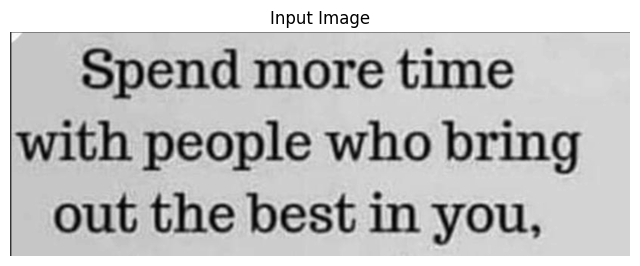

In [44]:
Plotter.PlotImage(img, title="Input Image")

### Filtering Input Image

- Unsharp Masking (USM)
- High-boost Filter


In [45]:
from src.image_processor.filters import *

In [46]:
unsharp_filter = FilterBuilder.Build(FilterType.UNSHARP_MASKING, strength=1.5)
unsharp_img =  unsharp_filter.Filter(img)

highboost_filter = FilterBuilder.Build(FilterType.HIGH_BOOST, A=1.7)
highboost_img = highboost_filter.Filter(img)

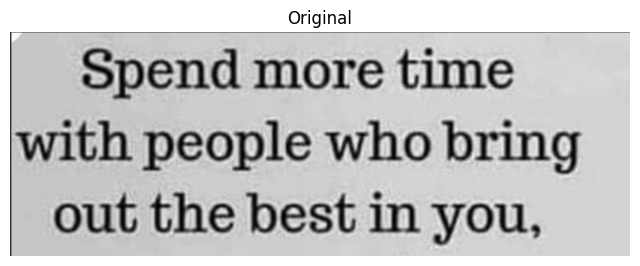

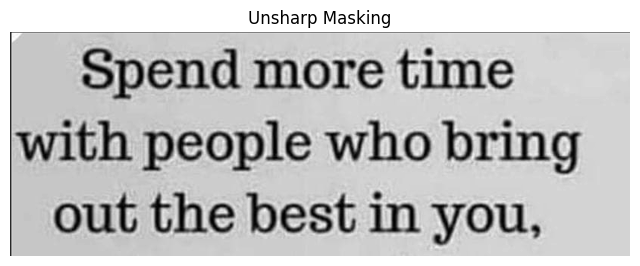

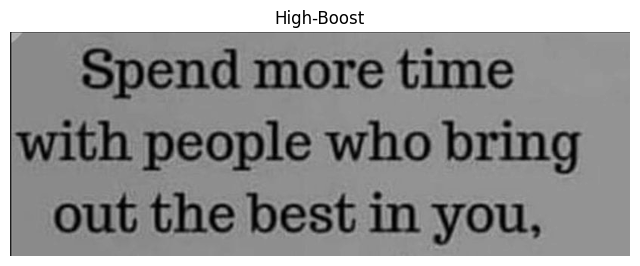

In [47]:
titles = ["Original", "Unsharp Masking", "High-Boost"]
images = [img, unsharp_img, highboost_img]

for i, (title, img) in enumerate(zip(titles, images)):
    Plotter.PlotImage(img, title=title)


**Note:** USM produces the best result, hence it is used in further steps.

In [48]:
filtered_img = unsharp_img

### Threasholding Filtered (Sharpened) Image

- Adaptive Gaussian Thresholding
- Otsu's Method
- Mode: Binary Inverted 

In [49]:
from src.image_processor.thresholding import *

In [50]:
adaptive_gaussian_thresh = ThresholdingBuilder.Build(
    ThresholdingType.ADAPTIVE_GAUSSIAN, 
    ThresholdingMode.BINARY_INV,
    sigma=1.0,
    block_size=11,
    C=2.0,
    max_value=255.0
)
adaptive_gaussian_thresh_img = adaptive_gaussian_thresh.ApplyThresholding(filtered_img)

otsu_thresh = ThresholdingBuilder.Build(
    ThresholdingType.OTSU,
    ThresholdingMode.BINARY_INV,
    max_value=255.0
)
otsu_thresh_img = otsu_thresh.ApplyThresholding(filtered_img)

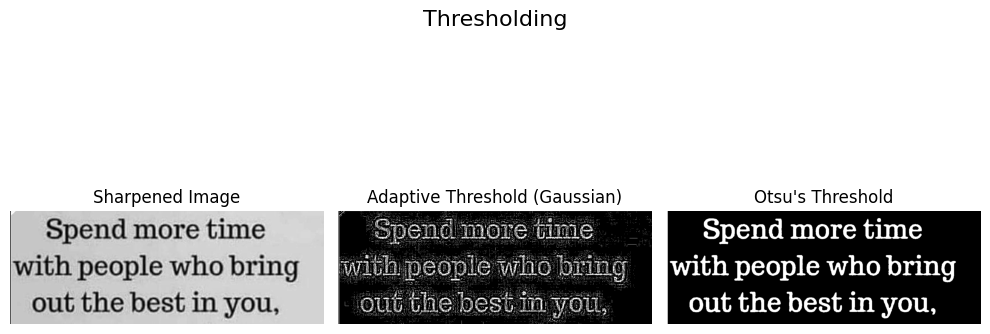

In [51]:
Plotter.PlotImages(
    [
        filtered_img,
        adaptive_gaussian_thresh_img,
        otsu_thresh_img,
    ],
    "Thresholding",
    ["Sharpened Image", "Adaptive Threshold (Gaussian)", "Otsu's Threshold"],
)

**Note:** Clearly, Otsu produces the best result here...

In [52]:
thresh_img = otsu_thresh_img

### Aligning the Thresholded Image

In [53]:
from src.utils import Aligner

In [54]:
aligned_img = Aligner.DeskewTextHorizontal(thresh_img)


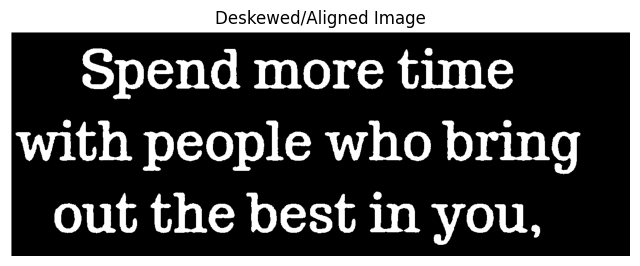

In [55]:
Plotter.PlotImage(aligned_img, title="Deskewed/Aligned Image")

In [56]:
save_img = False

In [57]:
if save_img:
    cv2.imwrite("./assets/test_deskewed.jpg", aligned_img)

### Segmentation of Aligned Image

- Line Segmentation (HPP)
- Word Segmentation (VPP)
- Character Segmentation (CCA)

In [58]:
from src.image_processor.segmentation import *

In [59]:
from src.image_processor.morphops import *

morphop_word = Closer(MorphKernelGenerator.GetSquareKernel(20))
morphop_char = Opener(MorphKernelGenerator.GetSquareKernel(5))
lines = SegmentationBuilder.Build(SegmentationType.HPP,threshold_ratio=0.05).Segment(aligned_img)
words = SegmentationBuilder.Build(SegmentationType.VPP,threshold_ratio = 0.1,
                                  morphop = morphop_word).Segment(lines[0])
chars = SegmentationBuilder.Build(SegmentationType.CCA,morphop = morphop_char).Segment(words[0])

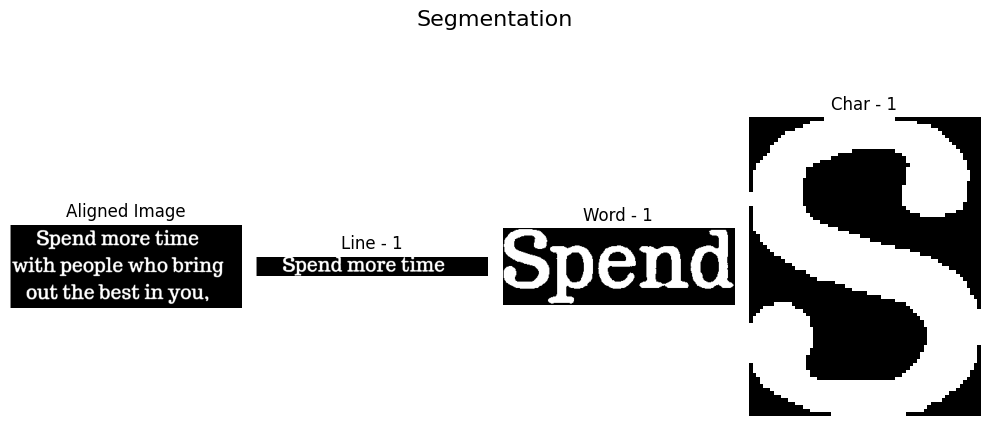

In [60]:
Plotter.PlotImages(
    [aligned_img, lines[0], words[0], chars[0]],
    "Segmentation",
    ["Aligned Image", "Line - 1", "Word - 1", "Char - 1"],
)

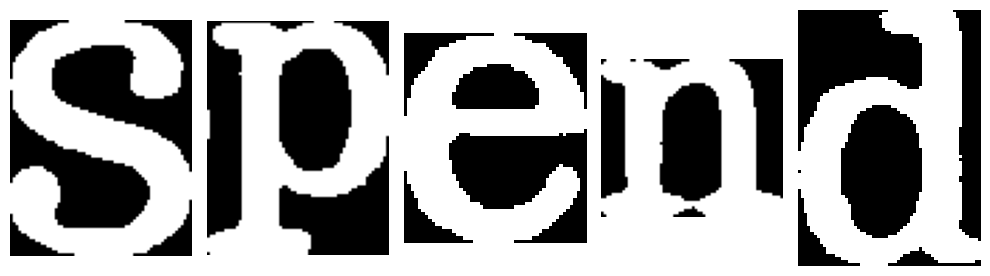

In [61]:
Plotter.PlotImages(chars)


### Apply Model

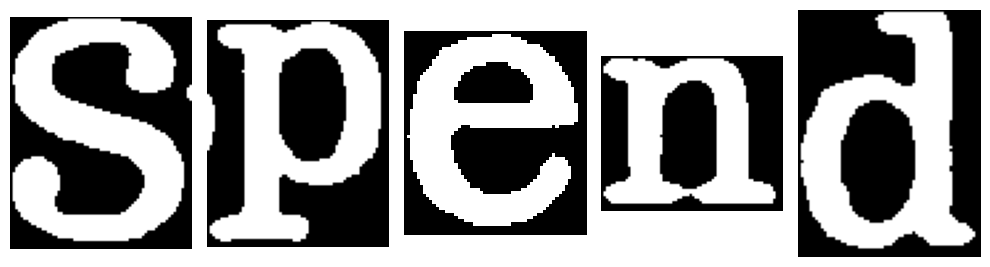

Char 0: Pred=Sample055 → 'S'
Char 1: Pred=Sample052 → 'P'
Char 2: Pred=Sample041 → 'E'
Char 3: Pred=Sample050 → 'N'
Char 4: Pred=Sample040 → 'D'


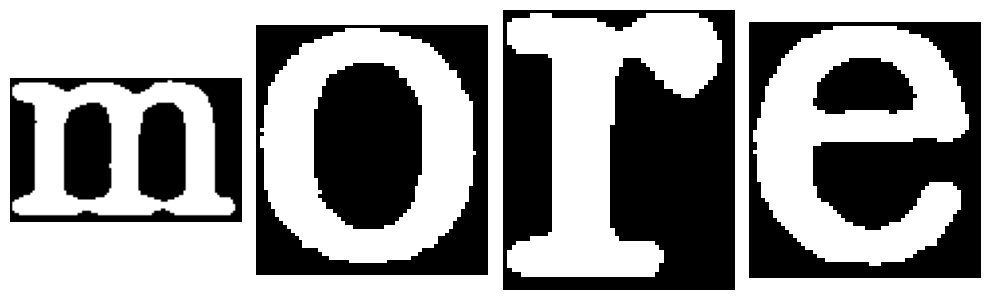

Char 0: Pred=Sample014 → 'd'
Char 1: Pred=Sample051 → 'O'
Char 2: Pred=Sample039 → 'C'
Char 3: Pred=Sample041 → 'E'


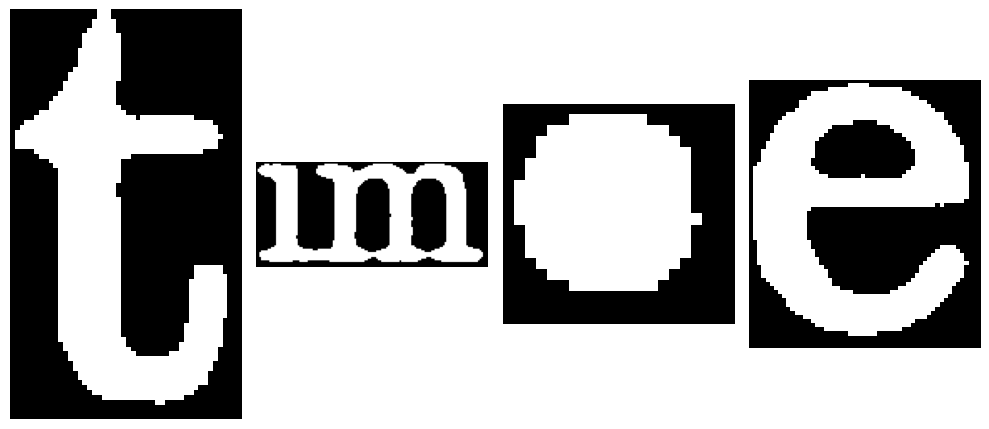

Char 0: Pred=Sample056 → 'T'
Char 1: Pred=Sample018 → 'h'
Char 2: Pred=Sample051 → 'O'
Char 3: Pred=Sample041 → 'E'


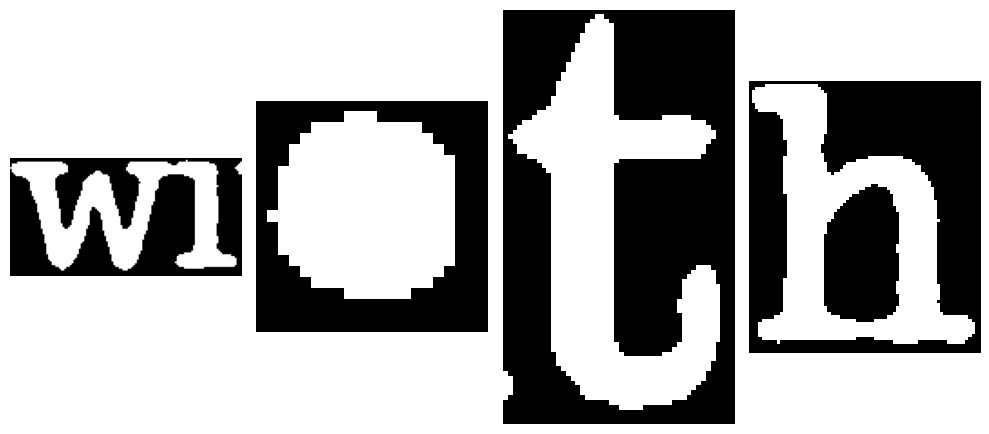

Char 0: Pred=Sample021 → 'k'
Char 1: Pred=Sample051 → 'O'
Char 2: Pred=Sample022 → 'l'
Char 3: Pred=Sample044 → 'H'


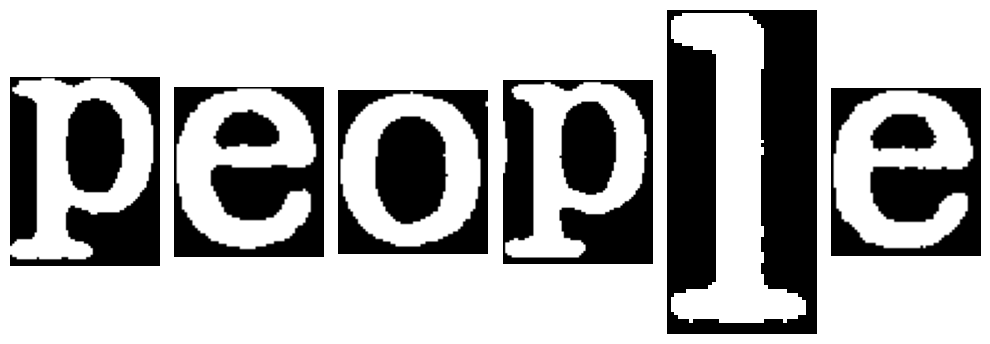

Char 0: Pred=Sample052 → 'P'
Char 1: Pred=Sample041 → 'E'
Char 2: Pred=Sample051 → 'O'
Char 3: Pred=Sample052 → 'P'
Char 4: Pred=Sample022 → 'l'
Char 5: Pred=Sample041 → 'E'


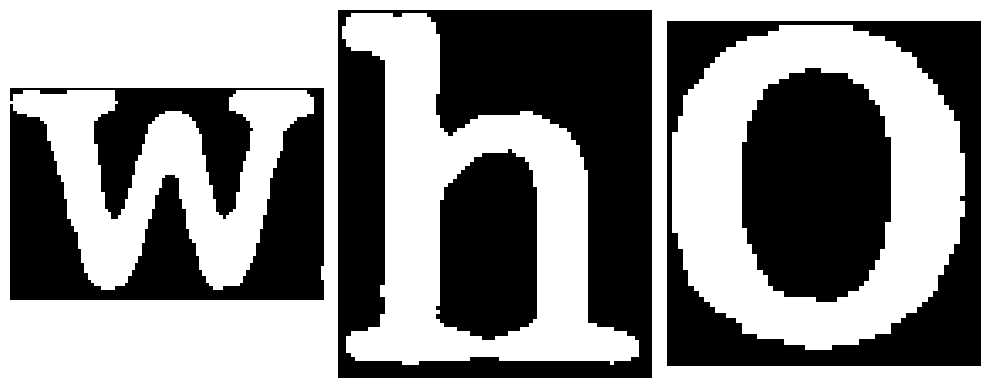

Char 0: Pred=Sample059 → 'W'
Char 1: Pred=Sample044 → 'H'
Char 2: Pred=Sample051 → 'O'


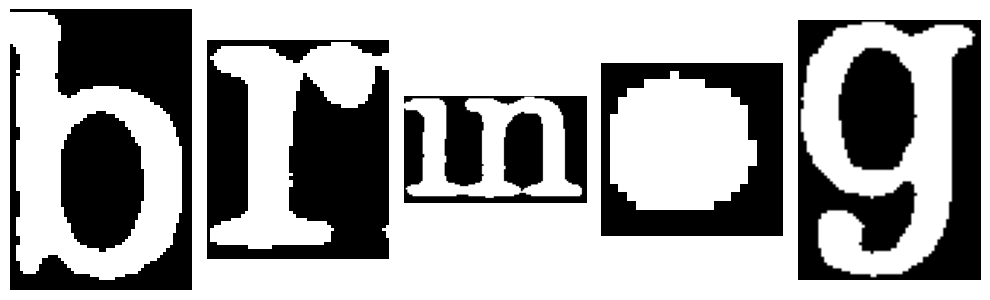

Char 0: Pred=Sample038 → 'B'
Char 1: Pred=Sample039 → 'C'
Char 2: Pred=Sample014 → 'd'
Char 3: Pred=Sample025 → 'o'
Char 4: Pred=Sample010 → '9'


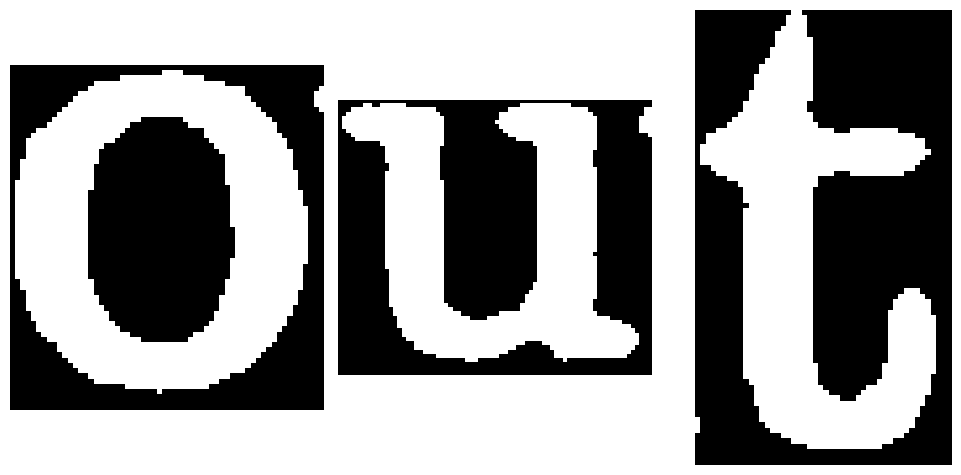

Char 0: Pred=Sample025 → 'o'
Char 1: Pred=Sample057 → 'U'
Char 2: Pred=Sample022 → 'l'


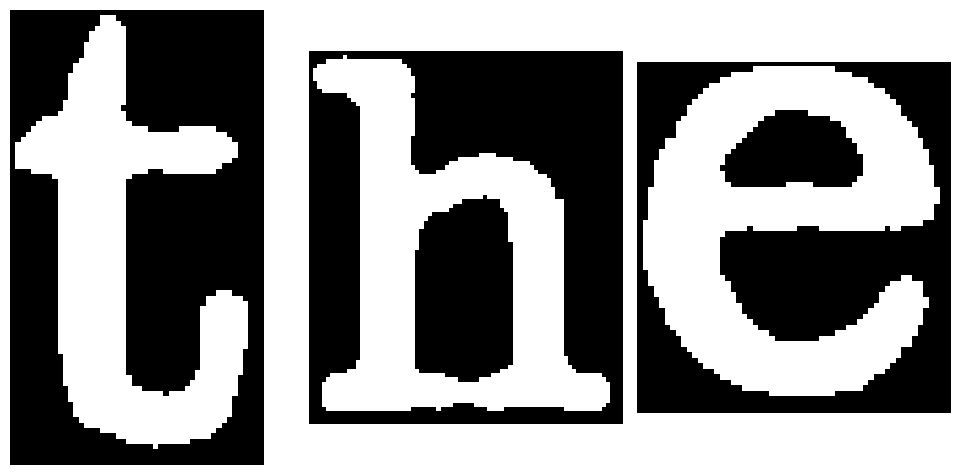

Char 0: Pred=Sample056 → 'T'
Char 1: Pred=Sample044 → 'H'
Char 2: Pred=Sample041 → 'E'


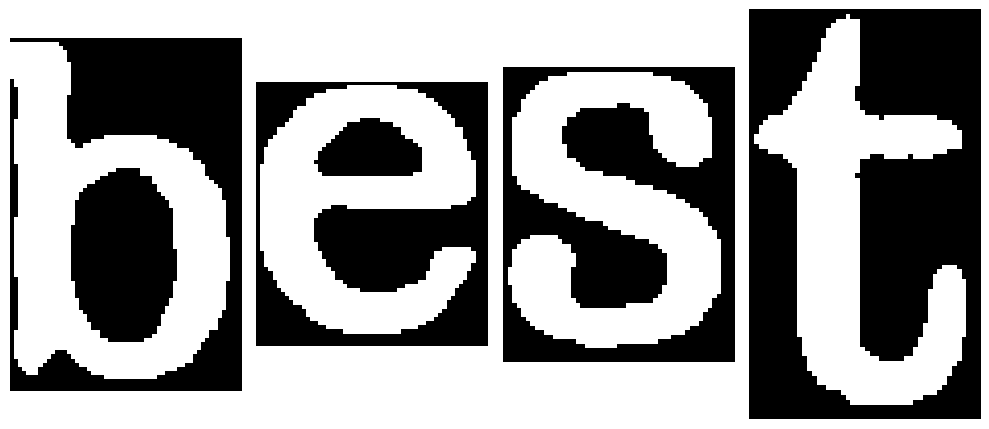

Char 0: Pred=Sample025 → 'o'
Char 1: Pred=Sample041 → 'E'
Char 2: Pred=Sample055 → 'S'
Char 3: Pred=Sample056 → 'T'


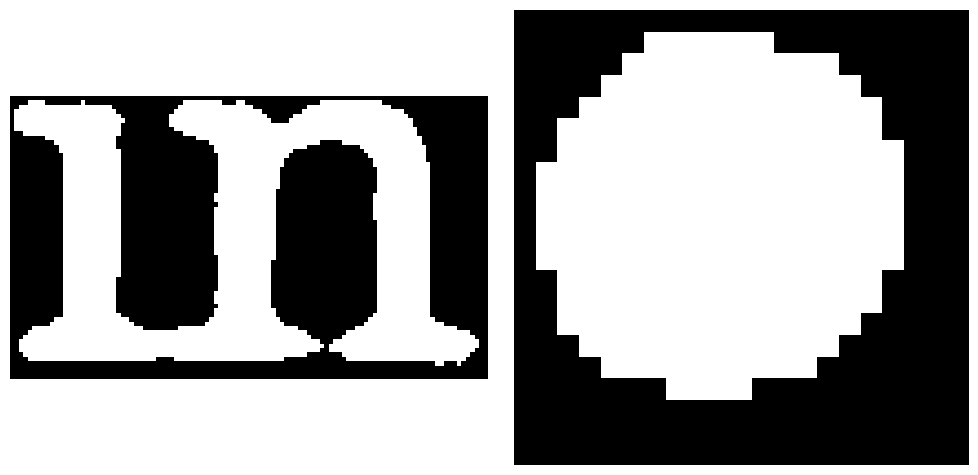

Char 0: Pred=Sample014 → 'd'
Char 1: Pred=Sample025 → 'o'


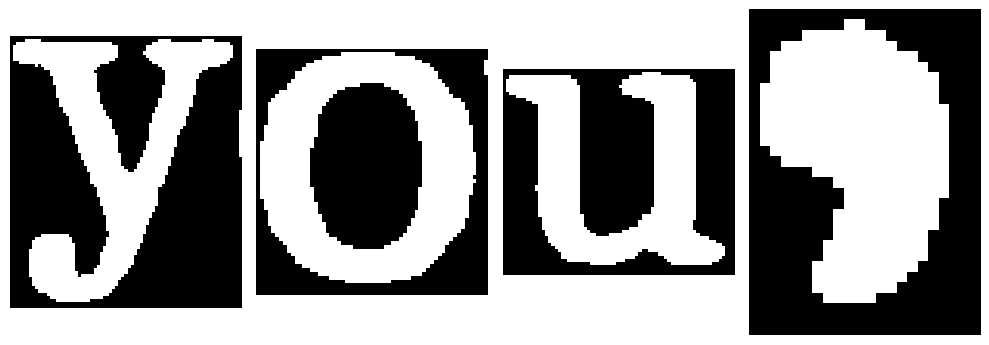

Char 0: Pred=Sample061 → 'Y'
Char 1: Pred=Sample051 → 'O'
Char 2: Pred=Sample057 → 'U'
Char 3: Pred=Sample010 → '9'


In [62]:
from src.ocr_predicter import RookieOCR
from src.image_processor.morphops import *

rookie_ocr = RookieOCR("./models/char74k_cnn.h5")
morphop_char = Opener(MorphKernelGenerator.GetCrossKernel(6))
detected_text = "" 
for line in lines:
    words = SegmentationBuilder.Build(SegmentationType.VPP, threshold_ratio = 0.12,morphop = morphop_word).Segment(line)
    for word in words:
        word_chars = SegmentationBuilder.Build(SegmentationType.COUNTOUR,morphop = morphop_char).Segment(word)
        Plotter.PlotImages(word_chars)
        detected_text += f"{rookie_ocr.recognize_word(word_chars)} "

In [63]:
detected_text

'SPEND dOCE ThOE kOlH PEOPlE WHO BCdo9 oUl THE oEST do YOU9 '

In [64]:
from src.pipelines import ImageProcessor

In [65]:
img_proc = ImageProcessor(PATH)

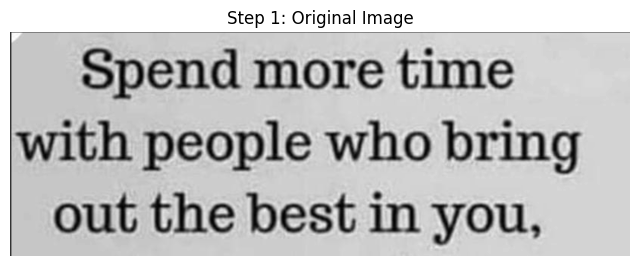

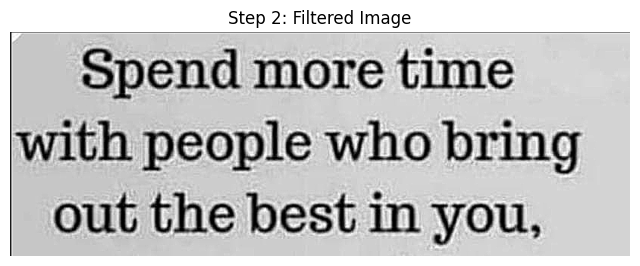

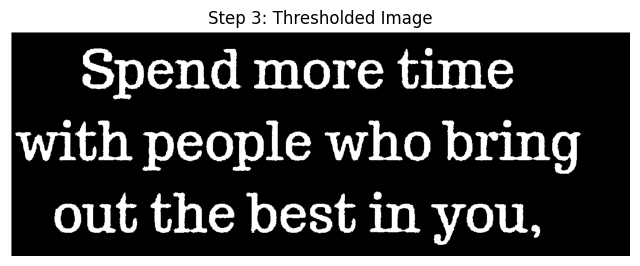

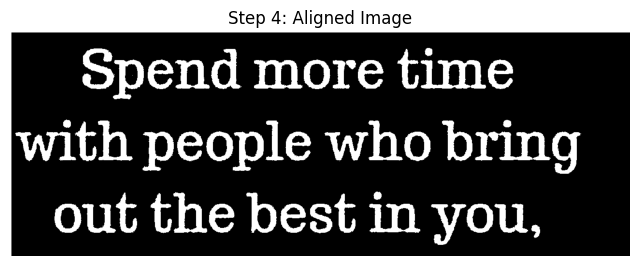

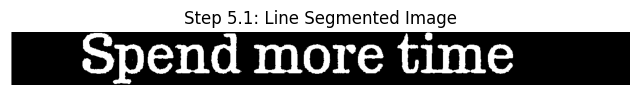

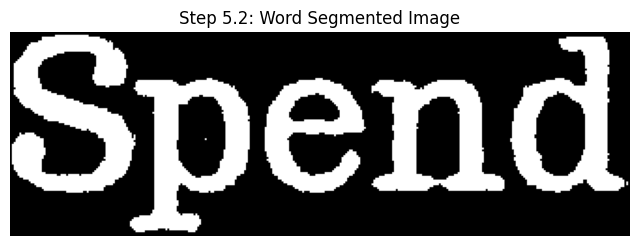

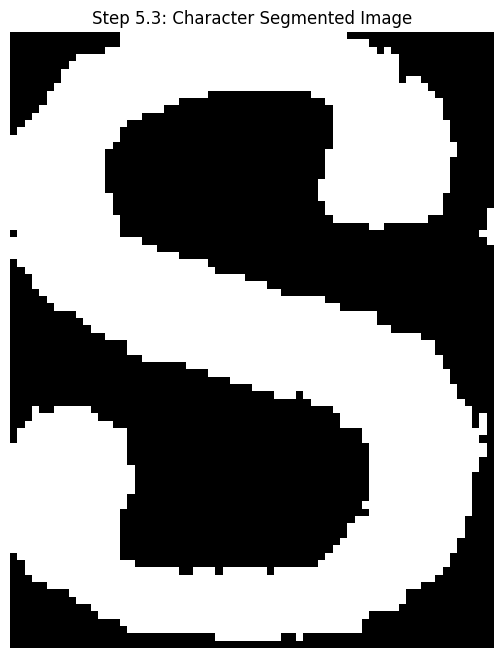

In [66]:
result = (
    img_proc.Plot(title="Step 1: Original Image")
    .Filter(FilterType.UNSHARP_MASKING, sigma=1.5, strength=5.0)
    .Plot(title="Step 2: Filtered Image")
    .Threshold(ThresholdingType.OTSU, ThresholdingMode.BINARY_INV)
    .Plot(title="Step 3: Thresholded Image")
    .Align()
    .Plot(title="Step 4: Aligned Image")
    .SegmentIntoLines(threshold_ratio=0.05)
    .PlotSegmentLine(index=0, title="Step 5.1: Line Segmented Image")
    .SegmentIntoWords(line_index=0, threshold_ratio=0.1, morphop=morphop_word)
    .PlotSegmentWord(index=0, title="Step 5.2: Word Segmented Image")
    .SegmentIntoChars(word_index=0, morphop=morphop_char)
    .PlotSegmentChar(index=0, title="Step 5.3: Character Segmented Image")
)

In [67]:
detected_text

'SPEND dOCE ThOE kOlH PEOPlE WHO BCdo9 oUl THE oEST do YOU9 '

### Optical Character Recognition (OCR)

In [68]:
import pytesseract
from paddleocr import PaddleOCR

from textwrap import fill
from tabulate import tabulate

In [69]:
# Text in our Image
sample = (
    "Every good programmer wants to develop software that is correct, which means that",
    "a program produces the right output for all the anticipated inputs in the program's",
    "application. In addition, we want software to be robust, that is, capable of handling",
    "unexpected inputs that are not explicitly defined for its application. For example,",
    "if a program is expecting a positive integer (perhaps representing the price of an",
    "item) and instead is given a negative integer, then the program should be able to",
    "recover gracefully from this error. More importantly, in life-critical applications,",
    "where a software error can lead to injury or loss of life, software that is not robust",
    "could be deadly. This point was driven home in the late 1980s in accidents involv-",
    "ing Therac-25, a radiation-therapy machine, which severely overdosed six patients",
    "between 1985 and 1987, some of whom died from complications resulting from",
    "their radiation overdose. All six accidents were traced to software errors.",
)
ocr_input = lines

print(" => Input Text:")
for line in sample:
    print(line)

 => Input Text:
Every good programmer wants to develop software that is correct, which means that
a program produces the right output for all the anticipated inputs in the program's
application. In addition, we want software to be robust, that is, capable of handling
unexpected inputs that are not explicitly defined for its application. For example,
if a program is expecting a positive integer (perhaps representing the price of an
item) and instead is given a negative integer, then the program should be able to
recover gracefully from this error. More importantly, in life-critical applications,
where a software error can lead to injury or loss of life, software that is not robust
could be deadly. This point was driven home in the late 1980s in accidents involv-
ing Therac-25, a radiation-therapy machine, which severely overdosed six patients
between 1985 and 1987, some of whom died from complications resulting from
their radiation overdose. All six accidents were traced to software err

In [ ]:
from paddleocr import PaddleOCR

In [94]:
paddle_ocr = PaddleOCR(lang="en")

output = []
for line in ocr_input:
    if len(line.shape) == 2:
        line = ColorConverter.ToBGR(line)
    result = paddle_ocr.predict(line)
    output.append(result)

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Ankur Majumdar\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Ankur Majumdar\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Ankur Majumdar\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Ankur Majumdar\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory

In [95]:
output_paddle = []
for result in output:
    for res in result:
        output_paddle.append(" ".join(res['rec_texts']))

print(" => Paddle OCR Output:")
for line in output_paddle:
    print(line)

 => Paddle OCR Output:
time
ntn people who bring
Dut the best in you,


In [96]:
output_tesseract = []
for line in ocr_input:
    output_tesseract.append(pytesseract.image_to_string(line))

print(" => Py-Tesseract OCR Output:")
for line in output_tesseract:
    print(line)

 => Py-Tesseract OCR Output:
Spend more time

with people who bring

. out the best in you,



##### Similarity Measures

- Cosine Similarity
- Hamming Distance
- Levenshtein Distance

In [97]:
op_paddle = " ".join(output_paddle)
op_tesseract = " ".join(output_tesseract)
sample_t = " ".join(sample)

cos_paddle = CVMath.CosineSimilarity(sample_t, op_paddle)
ham_paddle = CVMath.HammingDistance(sample_t, op_paddle)
lev_paddle = CVMath.LevenshteinDistance(sample_t, op_paddle)

cos_tesseract = CVMath.CosineSimilarity(sample_t, op_tesseract)
ham_tesseract = CVMath.HammingDistance(sample_t, op_tesseract)
lev_tesseract = CVMath.LevenshteinDistance(sample_t, op_tesseract)

In [98]:
WIDTH = 50

table = [
    [
        "PyTesseract-OCR",
        fill(output_tesseract[0].strip() + "...", WIDTH),
        cos_tesseract,
        ham_paddle,
        lev_paddle,
    ],
    [
        "Paddle-OCR",
        fill(output_paddle[0].strip() + "...", WIDTH),
        cos_paddle,
        ham_paddle,
        lev_paddle,
    ],
]

headers = [
    "OCR Engine", 
    "Extracted Text", 
    "COS",
    "HAM",
    "LEV"
]

print(
    tabulate(
        table,
        headers=headers,
        tablefmt="fancy_grid",
        colalign=("left", "left", "center", "center", "center"),
    ),
)

╒═════════════════╤════════════════════╤══════════╤═══════╤═══════╕
│ OCR Engine      │ Extracted Text     │   COS    │  HAM  │  LEV  │
╞═════════════════╪════════════════════╪══════════╪═══════╪═══════╡
│ PyTesseract-OCR │ Spend more time... │ 0.104159 │  835  │  945  │
├─────────────────┼────────────────────┼──────────┼───────┼───────┤
│ Paddle-OCR      │ time...            │ 0.103071 │  835  │  945  │
╘═════════════════╧════════════════════╧══════════╧═══════╧═══════╛


#### Using Rookie OCR Pipeline

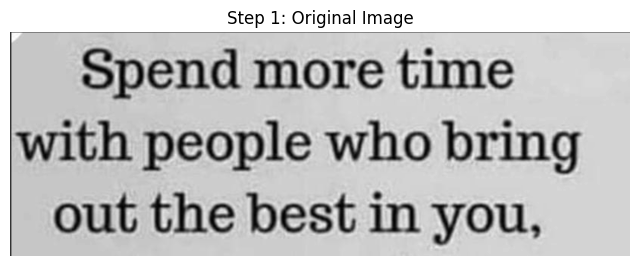

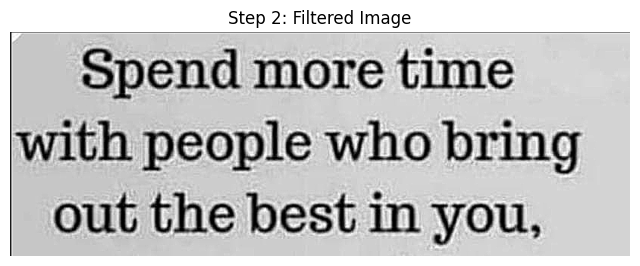

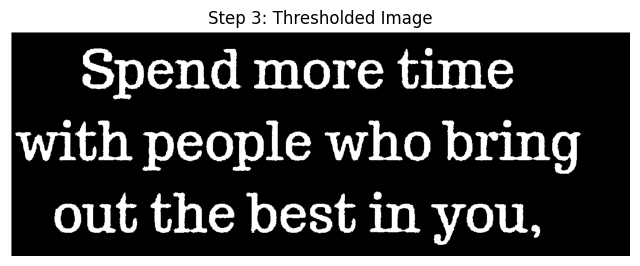

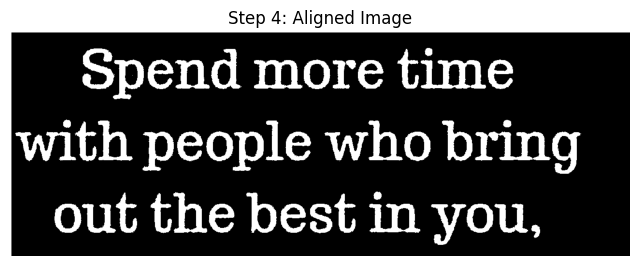

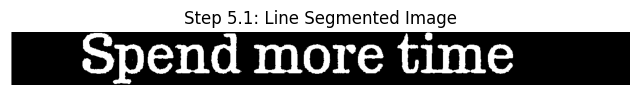

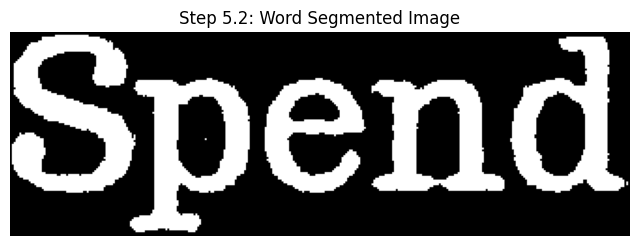

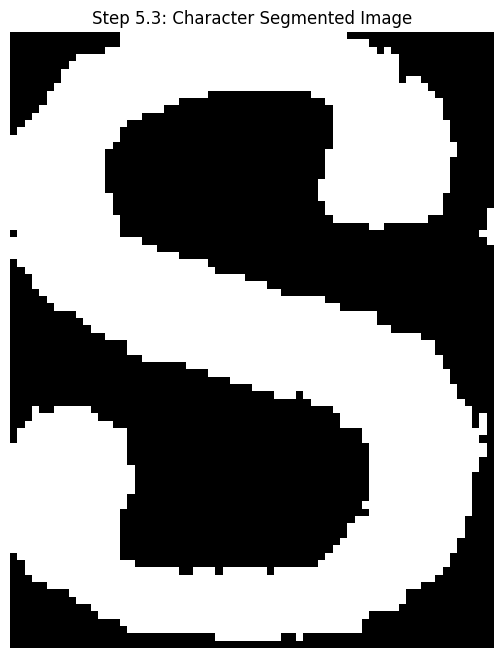

Char 0: Pred=Sample055 → 'S'
Char 1: Pred=Sample052 → 'P'
Char 2: Pred=Sample041 → 'E'
Char 3: Pred=Sample050 → 'N'
Char 4: Pred=Sample037 → 'A'
SPENA


In [99]:
from src.pipelines import OCRPipeline

ocr_pipe = OCRPipeline(PATH, "./models/char74k_cnn.h5")
result = (
    ocr_pipe.Plot(title="Step 1: Original Image")
    .Filter(FilterType.UNSHARP_MASKING, sigma=1.5, strength=5.0)
    .Plot(title="Step 2: Filtered Image")
    .Threshold(ThresholdingType.OTSU, ThresholdingMode.BINARY_INV)
    .Plot(title="Step 3: Thresholded Image")
    .Align()
    .Plot(title="Step 4: Aligned Image")
    .SegmentIntoLines(threshold_ratio=0.05)
    .PlotSegmentLine(index=0, title="Step 5.1: Line Segmented Image")
    .SegmentIntoWords(line_index=0, threshold_ratio=0.1, morphop=morphop_word)
    .PlotSegmentWord(index=0, title="Step 5.2: Word Segmented Image")
    .SegmentIntoChars(word_index=0, morphop=morphop_char)
    .PlotSegmentChar(index=0, title="Step 5.3: Character Segmented Image")
    .OCR()
    .PrintPredictedString()
)